In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import xgboost as xgb
pd.set_option('max_columns',100)
warnings.filterwarnings('ignore')

In [2]:
#getting team1 and team2 from winning and losing team data
import random
def data_mix(short):
    team1 = []
    team2 = []
    fgperc_1 = []
    fgperc_2 = []
    fg3perc_1 = []
    fg3perc_2 = []
    ftperc_1 = []
    ftperc_2 = []
    or_1 = []
    or_2 = []
    dr_1 = []
    dr_2 = []
    ast_1 = []
    ast_2 = []
    to_1 = []
    to_2 = []
    stl_1 = []
    stl_2 = []
    blk_1 = []
    blk_2 = []
    pf_1 = []
    pf_2 = []
    h_adv = []
    win = []
    season = []
    daynum = []
    for j in range(len(short)):
        x = random.uniform(0,1)
        season.append(short['Season'][j])
        daynum.append(short['DayNum'][j])
        if x>=0.5:
            team1.append(short['WTeamID'][j])
            team2.append(short['LTeamID'][j])
            fgperc_1.append(short['WFG%'][j])
            fg3perc_1.append(short['WFG3%'][j])
            ftperc_1.append(short['WFT%'][j])
            or_1.append(short['WOR'][j])
            dr_1.append(short['WDR'][j])
            ast_1.append(short['WAst'][j])
            to_1.append(short['WTO'][j])
            stl_1.append(short['WStl'][j])
            blk_1.append(short['WBlk'][j])
            pf_1.append(short['WPF'][j])
            fgperc_2.append(short['LFG%'][j])
            fg3perc_2.append(short['LFG3%'][j])
            ftperc_2.append(short['LFT%'][j])
            or_2.append(short['LOR'][j])
            dr_2.append(short['LDR'][j])
            ast_2.append(short['LAst'][j])
            to_2.append(short['LTO'][j])
            stl_2.append(short['LStl'][j])
            blk_2.append(short['LBlk'][j])
            pf_2.append(short['LPF'][j])
            if short['WLoc'][j] is 'H':
                h_adv.append(1)
            elif short['WLoc'][j] is 'A':
                h_adv.append(-1)
            elif short['WLoc'][j] is 'N':
                h_adv.append(0)
            win.append(1)
        else:
            team1.append(short['LTeamID'][j])
            team2.append(short['WTeamID'][j])
            fgperc_1.append(short['LFG%'][j])
            fg3perc_1.append(short['LFG3%'][j])
            ftperc_1.append(short['LFT%'][j])
            or_1.append(short['LOR'][j])
            dr_1.append(short['LDR'][j])
            ast_1.append(short['LAst'][j])
            to_1.append(short['LTO'][j])
            stl_1.append(short['LStl'][j])
            blk_1.append(short['LBlk'][j])
            pf_1.append(short['LPF'][j])
            fgperc_2.append(short['WFG%'][j])
            fg3perc_2.append(short['WFG3%'][j])
            ftperc_2.append(short['WFT%'][j])
            or_2.append(short['WOR'][j])
            dr_2.append(short['WDR'][j])
            ast_2.append(short['WAst'][j])
            to_2.append(short['WTO'][j])
            stl_2.append(short['WStl'][j])
            blk_2.append(short['WBlk'][j])
            pf_2.append(short['WPF'][j])
            if short['WLoc'][j] is 'H':
                h_adv.append(-1)
            elif short['WLoc'][j] is 'A':
                h_adv.append(1)
            elif short['WLoc'][j] is 'N':
                h_adv.append(0)
            win.append(0)

    tot = list(zip(season,daynum,team1,team2,h_adv,fgperc_1,fg3perc_1,ftperc_1,or_1,dr_1,ast_1,to_1,stl_1,blk_1,pf_1,
                    fgperc_2,fg3perc_2,ftperc_2,or_2,dr_2,ast_2,to_2,stl_2,blk_2,pf_2,win))
    short_f = pd.DataFrame(tot,columns = ['Season','DayNum','Team1','Team2','Home_Adv','FG%_1','FG3%_1','FT%_1','OR_1','DR_1','AST_1','TO_1','STL_1',
                                          'BLK_1','PF_1','FG%_2','FG3%_2','FT%_2','OR_2','DR_2','AST_2','TO_2','STL_2',
                                          'BLK_2','PF_2','Win'])
    return short_f

In [3]:
#all time stats for a team
def get_stats(team_id,data):
    return data[(data['Team1']==team_id)| (data['Team2']==team_id)].reset_index(drop=True).dropna()

#yearly stats for a team
def get_stats_year(team_id,season,data):
    return data[((data['Team1']==team_id)|(data['Team2']==team_id))&(data['Season']==season)].reset_index(drop=True).dropna()

#season stats
def get_season(season,data):
    return data[data['Season']==season].reset_index(drop=True).dropna()

#regular season stats
def get_season_reg(season,data):
    return data[(data['Season']==season)&(data['DayNum']<134)].reset_index(drop=True).dropna()

#stats till season
def get_stats_till(season,data):
    return data[(data['Season']<season)].reset_index(drop=True).dropna()

In [ ]:
teams = pd.read_csv('MTeams.csv')
teams.head(10)

In [ ]:
len(teams.TeamID)

In [4]:
def get_avg_stats(teamid,year,data):
    stats_team = get_stats_year(teamid,year,data)
    s = pd.DataFrame(columns=['Season','DayNum','GameNum','Team','Against','FG%_s', 'FG3%_s','FT%_s', 'OR_s',
                              'DR_s', 'AST_s', 'TO_s', 'STL_s', 'BLK_s', 'PF_s','FG%_a', 
                              'FG3%_a', 'FT%_a', 'OR_a', 'DR_a', 'AST_a', 'TO_a', 'STL_a','BLK_a', 'PF_a'])
    for i in range(1,len(stats_team)):
        fgperc_s = 0
        fgperc_a = 0
        fg3perc_s = 0
        fg3perc_a = 0
        ftperc_s = 0
        ftperc_a = 0
        or_s = 0
        or_a = 0
        dr_s = 0
        dr_a = 0
        ast_s = 0
        ast_a = 0
        to_s = 0
        to_a = 0
        stl_s = 0
        stl_a = 0
        blk_s = 0
        blk_a = 0
        pf_s = 0
        pf_a = 0
        fgperc_s_avg = 0
        fgperc_a_avg = 0
        fg3perc_s_avg = 0
        fg3perc_a_avg = 0
        ftperc_s_avg = 0
        ftperc_a_avg = 0
        or_s_avg = 0
        or_a_avg = 0
        dr_s_avg = 0
        dr_a_avg = 0
        ast_s_avg = 0
        ast_a_avg = 0
        to_s_avg = 0
        to_a_avg = 0
        stl_s_avg = 0
        stl_a_avg = 0
        blk_s_avg = 0
        blk_a_avg = 0
        pf_s_avg = 0
        pf_a_avg = 0
        for j in range(i):
            if (stats_team.loc[[j]]['Team1'].values[0] == teamid):
                fgperc_s += (stats_team.loc[[j]]['FG%_1'].values[0])
                fg3perc_s += (stats_team.loc[[j]]['FG3%_1'].values[0])
                ftperc_s += (stats_team.loc[[j]]['FT%_1'].values[0])
                or_s += (stats_team.loc[[j]]['OR_1'].values[0])
                dr_s += (stats_team.loc[[j]]['DR_1'].values[0])
                ast_s += (stats_team.loc[[j]]['AST_1'].values[0])
                to_s += (stats_team.loc[[j]]['TO_1'].values[0])
                stl_s += (stats_team.loc[[j]]['STL_1'].values[0])
                blk_s += (stats_team.loc[[j]]['BLK_1'].values[0])
                pf_s += (stats_team.loc[[j]]['PF_1'].values[0])
                fgperc_a += (stats_team.loc[[j]]['FG%_2'].values[0])
                fg3perc_a += (stats_team.loc[[j]]['FG3%_2'].values[0])
                ftperc_a += (stats_team.loc[[j]]['FT%_2'].values[0])
                or_a += (stats_team.loc[[j]]['OR_2'].values[0])
                dr_a += (stats_team.loc[[j]]['DR_2'].values[0])
                ast_a += (stats_team.loc[[j]]['AST_2'].values[0])
                to_a += (stats_team.loc[[j]]['TO_2'].values[0])
                stl_a += (stats_team.loc[[j]]['STL_2'].values[0])
                blk_a += (stats_team.loc[[j]]['BLK_2'].values[0])
                pf_a += (stats_team.loc[[j]]['PF_2'].values[0])
            elif (stats_team.loc[[j]]['Team2'].values[0] == teamid):
                fgperc_s += (stats_team.loc[[j]]['FG%_2'].values[0])
                fg3perc_s += (stats_team.loc[[j]]['FG3%_2'].values[0])
                ftperc_s += (stats_team.loc[[j]]['FT%_2'].values[0])
                or_s += (stats_team.loc[[j]]['OR_2'].values[0])
                dr_s += (stats_team.loc[[j]]['DR_2'].values[0])
                ast_s += (stats_team.loc[[j]]['AST_2'].values[0])
                to_s += (stats_team.loc[[j]]['TO_2'].values[0])
                stl_s += (stats_team.loc[[j]]['STL_2'].values[0])
                blk_s += (stats_team.loc[[j]]['BLK_2'].values[0])
                pf_s += (stats_team.loc[[j]]['PF_2'].values[0])
                fgperc_a += (stats_team.loc[[j]]['FG%_1'].values[0])
                fg3perc_a += (stats_team.loc[[j]]['FG3%_1'].values[0])
                ftperc_a += (stats_team.loc[[j]]['FT%_1'].values[0])
                or_a += (stats_team.loc[[j]]['OR_1'].values[0])
                dr_a += (stats_team.loc[[j]]['DR_1'].values[0])
                ast_a += (stats_team.loc[[j]]['AST_1'].values[0])
                to_a += (stats_team.loc[[j]]['TO_1'].values[0])
                stl_a += (stats_team.loc[[j]]['STL_1'].values[0])
                blk_a += (stats_team.loc[[j]]['BLK_1'].values[0])
                pf_a += (stats_team.loc[[j]]['PF_1'].values[0])
        fgperc_s_avg = (fgperc_s/i)
        fg3perc_s_avg = (fg3perc_s/i)
        ftperc_s_avg = (ftperc_s/i)
        or_s_avg = (or_s/i)
        dr_s_avg = (dr_s/i)
        ast_s_avg = (ast_s/i)
        to_s_avg = (to_s/i)
        stl_s_avg = (stl_s/i)
        blk_s_avg = (blk_s/i)
        pf_s_avg = (pf_s/i)
        fgperc_a_avg = (fgperc_a/i)
        fg3perc_a_avg = (fg3perc_a/i)
        ftperc_a_avg = (ftperc_a/i)
        or_a_avg = (or_a/i)
        dr_a_avg = (dr_a/i)
        ast_a_avg = (ast_a/i)
        to_a_avg = (to_a/i)
        stl_a_avg = (stl_a/i)
        blk_a_avg = (blk_a/i)
        pf_a_avg = (pf_a/i)
        if (stats_team.loc[[i]]['Team1'].values[0] == teamid):
            against = stats_team.loc[[i]]['Team2'].values[0]
        elif (stats_team.loc[[i]]['Team2'].values[0] == teamid):
            against = stats_team.loc[[i]]['Team1'].values[0]
        s = s.append({'Season':year,'DayNum':stats_team.loc[[i]]['DayNum'].values[0],'GameNum':int(i),'Team':int(teamid),
                      'FG%_s':fgperc_s_avg,'FG3%_s':fg3perc_s_avg,'FT%_s':ftperc_s_avg,'OR_s':or_s_avg,'DR_s':dr_s_avg,
                      'AST_s':ast_s_avg,'TO_s':to_s_avg,'STL_s':stl_s_avg,'BLK_s':blk_s_avg, 'PF_s':pf_s_avg,
                      'FG%_a':fgperc_a_avg,'FG3%_a':fg3perc_a_avg,'FT%_a':ftperc_a_avg,'OR_a':or_a_avg,'DR_a':dr_a_avg,
                      'AST_a':ast_a_avg,'TO_a':to_a_avg,'STL_a':stl_a_avg,'BLK_a':blk_a_avg,
                      'PF_a':pf_a_avg,'Against':against},ignore_index=True)
    return s

In [5]:
def get_avg_year_stats(Y,final):
    main = final.loc[:,['Season','DayNum','Team1','Team2','Home_Adv','Win']]
    main = main[main['Season']==Y][500:2000]
    training_data = pd.DataFrame(columns = ['Season','DayNum','Team1','Team2','Home_Adv','Win',
                                            '1FG%_s', '1FG3%_s','1FT%_s', '1OR_s','1DR_s', '1AST_s', '1TO_s', '1STL_s',
                                            '1BLK_s', '1PF_s','1FG%_a','1FG3%_a', '1FT%_a', '1OR_a','1DR_a', '1AST_a',
                                            '1TO_a', '1STL_a','1BLK_a', '1PF_a','2FG%_s', '2FG3%_s','2FT%_s', '2OR_s',
                                            '2DR_s', '2AST_s', '2TO_s', '2STL_s', '2BLK_s', '2PF_s','2FG%_a','2FG3%_a',
                                            '2FT%_a', '2OR_a','2DR_a', '2AST_a', '2TO_a', '2STL_a','2BLK_a', '2PF_a'])
    cols = ['1FG%_s', '1FG3%_s','1FT%_s', '1OR_s','1DR_s', '1AST_s', '1TO_s', '1STL_s',
            '1BLK_s', '1PF_s','1FG%_a','1FG3%_a', '1FT%_a', '1OR_a','1DR_a', '1AST_a',
            '1TO_a', '1STL_a','1BLK_a', '1PF_a','2FG%_s', '2FG3%_s','2FT%_s', '2OR_s',
            '2DR_s', '2AST_s', '2TO_s', '2STL_s', '2BLK_s', '2PF_s','2FG%_a','2FG3%_a',
            '2FT%_a', '2OR_a','2DR_a', '2AST_a', '2TO_a', '2STL_a','2BLK_a', '2PF_a']
    cols1 = ['Season','DayNum','Team1','Team2','Home_Adv','Win',
             '1FG%_s', '1FG3%_s','1FT%_s', '1OR_s','1DR_s', '1AST_s', '1TO_s', '1STL_s',
             '1BLK_s', '1PF_s','1FG%_a','1FG3%_a', '1FT%_a', '1OR_a','1DR_a', '1AST_a',
             '1TO_a', '1STL_a','1BLK_a', '1PF_a','2FG%_s', '2FG3%_s','2FT%_s', '2OR_s',
             '2DR_s', '2AST_s', '2TO_s', '2STL_s', '2BLK_s', '2PF_s','2FG%_a','2FG3%_a',
             '2FT%_a', '2OR_a','2DR_a', '2AST_a', '2TO_a', '2STL_a','2BLK_a', '2PF_a']
    count = 0
    for t1,t2 in zip(main.Team1,main.Team2):
        print (count)
        print (t1,t2)
        t = main[((main['Team1']==t1)&(main['Team2']==t2))|((main['Team2']==t1)&(main['Team1']==t2))].reset_index(drop=True)
        d1 = get_avg_stats(t1,Y,final_2015)
        d1 = d1[d1['Against']==t2].reset_index(drop=True)
        d2 = get_avg_stats(t2,Y,final_2015)
        d2 = d2[d2['Against']==t1].reset_index(drop=True)
        d1 = d1.drop(columns=['Season','DayNum','GameNum','Team','Against'])
        d2 = d2.drop(columns=['Season','DayNum','GameNum','Team','Against'])
        d = pd.concat([d1,d2],ignore_index=True,axis=1).reset_index(drop=True)
        d.columns = cols
        t = pd.concat([t,d],ignore_index=True,axis=1).reset_index(drop=True)
        t.columns = cols1
        training_data = training_data.append(t,ignore_index=True).reset_index(drop=True)
        count+=1
    return training_data.dropna()

In [16]:
'''
d_2003 = get_avg_year_stats(2003,final_2015)
d_2003
d_2003.to_csv('d_2003.csv')
'''

"\nd_2003 = get_avg_year_stats(2003,final_2015)\nd_2003\nd_2003.to_csv('d_2003.csv')\n"

In [6]:
final = pd.read_csv('final_mm_data.csv')

In [7]:
print(final.shape)
final.head(10)

(9656, 46)


,Season,DayNum,Team1,Team2,Home_Adv,Win,1FG%_s,1FG3%_s,1FT%_s,1OR_s,1DR_s,1AST_s,1TO_s,1STL_s,1BLK_s,1PF_s,1FG%_a,1FG3%_a,1FT%_a,1OR_a,1DR_a,1AST_a,1TO_a,1STL_a,1BLK_a,1PF_a,2FG%_s,2FG3%_s,2FT%_s,2OR_s,2DR_s,2AST_s,2TO_s,2STL_s,2BLK_s,2PF_s,2FG%_a,2FG3%_a,2FT%_a,2OR_a,2DR_a,2AST_a,2TO_a,2STL_a,2BLK_a,2PF_a
0,2003.0,12.0,1457.0,1186.0,0.0,0.0,0.367347,0.272727,0.533333,17.0,20.0,9.0,19.0,4.0,3.0,23.0,0.473684,0.333333,0.548387,6.0,19.0,11.0,12.0,14.0,2.0,18.0,0.434783,0.272727,0.705882,6.0,22.0,8.0,19.0,4.0,3.0,25.0,0.456140,0.500000,0.851852,12.0,24.0,12.0,9.0,9.0,3.0,18.0
1,2003.0,12.0,1458.0,1296.0,1.0,1.0,0.456140,0.500000,0.851852,12.0,24.0,12.0,9.0,9.0,3.0,18.0,0.434783,0.272727,0.705882,6.0,22.0,8.0,19.0,4.0,3.0,25.0,0.473684,0.333333,0.548387,6.0,19.0,11.0,12.0,14.0,2.0,18.0,0.367347,0.272727,0.533333,17.0,20.0,9.0,19.0,4.0,3.0,23.0
2,2003.0,14.0,1125.0,1135.0,0.0,1.0,0.281250,0.333333,0.500000,14.0,26.0,12.0,17.0,10.0,0.0,17.0,0.446429,0.434783,0.695652,8.0,35.0,18.0,13.0,14.0,19.0,13.0,0.428571,0.315789,0.647059,14.0,21.0,17.0,18.0,8.0,4.0,13.0,0.393939,0.263158,0.692308,21.0,23.0,15.0,17.0,12.0,3.0,17.0
3,2003.0,14.0,1156.0,1236.0,0.0,1.0,0.461538,0.333333,0.444444,13.0,26.0,13.0,25.0,8.0,2.0,18.0,0.482759,0.454545,0.555556,9.0,22.0,9.0,17.0,9.0,2.0,23.0,0.463415,0.266667,0.714286,9.0,21.0,11.0,30.0,10.0,4.0,28.0,0.418182,0.250000,0.820513,13.0,18.0,14.0,17.0,11.0,1.0,25.0
4,2003.0,14.0,1194.0,1161.0,-1.0,0.0,0.482759,0.454545,0.555556,9.0,22.0,9.0,17.0,9.0,2.0,23.0,0.461538,0.333333,0.444444,13.0,26.0,13.0,25.0,8.0,2.0,18.0,0.418182,0.250000,0.820513,13.0,18.0,14.0,17.0,11.0,1.0,25.0,0.463415,0.266667,0.714286,9.0,21.0,11.0,30.0,10.0,4.0,28.0
5,2003.0,14.0,1202.0,1166.0,-1.0,0.0,0.568627,0.538462,0.818182,6.0,21.0,18.0,15.0,7.0,1.0,5.0,0.460317,0.454545,1.000000,13.0,16.0,15.0,12.0,6.0,2.0,12.0,0.594203,0.600000,0.692308,15.0,29.0,21.0,11.0,10.0,6.0,16.0,0.326923,0.363636,0.705882,8.0,15.0,8.0,17.0,7.0,3.0,15.0
6,2003.0,14.0,1323.0,1237.0,1.0,1.0,0.446429,0.434783,0.695652,8.0,35.0,18.0,13.0,14.0,19.0,13.0,0.281250,0.333333,0.500000,14.0,26.0,12.0,17.0,10.0,0.0,17.0,0.393939,0.263158,0.692308,21.0,23.0,15.0,17.0,12.0,3.0,17.0,0.428571,0.315789,0.647059,14.0,21.0,17.0,18.0,8.0,4.0,13.0
7,2003.0,14.0,1106.0,1426.0,0.0,0.0,0.460317,0.454545,1.000000,13.0,16.0,15.0,12.0,6.0,2.0,12.0,0.568627,0.538462,0.818182,6.0,21.0,18.0,15.0,7.0,1.0,5.0,0.326923,0.363636,0.705882,8.0,15.0,8.0,17.0,7.0,3.0,15.0,0.594203,0.600000,0.692308,15.0,29.0,21.0,11.0,10.0,6.0,16.0
8,2003.0,15.0,1156.0,1161.0,-1.0,0.0,0.524247,0.444444,0.513889,10.5,25.5,15.5,20.0,5.0,4.0,18.0,0.471379,0.402273,0.652778,7.5,19.5,15.0,14.0,7.0,1.5,22.0,0.438258,0.333333,0.782349,14.5,25.0,13.5,20.5,8.0,2.0,22.0,0.393246,0.210256,0.672932,12.5,19.5,10.5,23.0,12.5,3.5,32.0
9,2003.0,15.0,1236.0,1194.0,0.0,0.0,0.461707,0.308333,0.732143,7.5,19.0,16.0,20.5,7.5,2.5,24.5,0.502569,0.402778,0.701923,10.5,21.5,16.0,16.0,6.5,3.5,21.5,0.402918,0.304196,0.593567,12.5,20.0,9.5,16.5,12.0,2.5,29.5,0.459936,0.375000,0.594315,14.5,29.0,13.0,24.5,6.5,2.5,18.5


In [8]:
X = final.loc[:,['Home_Adv','1FG%_s', '1FG3%_s','1FT%_s', '1OR_s','1DR_s', '1AST_s', '1TO_s', '1STL_s',
                     '1BLK_s', '1PF_s','1FG%_a','1FG3%_a', '1FT%_a', '1OR_a','1DR_a', '1AST_a',
                     '1TO_a', '1STL_a','1BLK_a', '1PF_a','2FG%_s', '2FG3%_s','2FT%_s', '2OR_s',
                     '2DR_s', '2AST_s', '2TO_s', '2STL_s', '2BLK_s', '2PF_s','2FG%_a','2FG3%_a',
                     '2FT%_a', '2OR_a','2DR_a', '2AST_a', '2TO_a', '2STL_a','2BLK_a', '2PF_a']]
y = final.loc[:,['Win']]
print (X.shape)
print (y.shape)

(9656, 41)
(9656, 1)


In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [10]:
#logistic regression

logreg = LogisticRegression().fit(X_train,y_train)
coeff_logreg = pd.DataFrame(X.columns)
coeff_logreg.columns = ['feature']
coeff_logreg["score_logreg"] = pd.Series(logreg.coef_[0])
coeff_logreg = coeff_logreg.sort_values(by=['score_logreg'],ascending=False).reset_index(drop=True)
coeff_logreg

,feature,score_logreg
0,Home_Adv,0.866492
1,1FT%_s,0.232182
2,2TO_s,0.145513
3,1FG%_s,0.092439
4,2DR_a,0.091301
5,1BLK_s,0.087321
6,2FG%_a,0.077299
7,1AST_s,0.070235
8,1DR_s,0.057907
9,1STL_s,0.042343


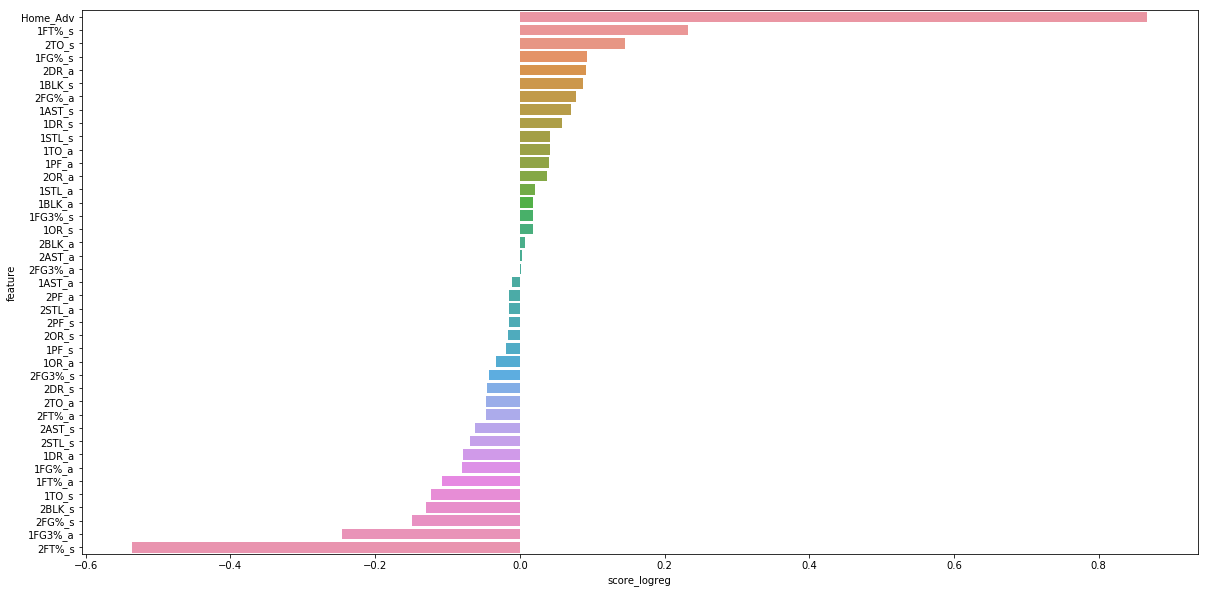

In [11]:

plt.figure(figsize = (20,10))
sns.barplot(x='score_logreg',y='feature',data=coeff_logreg)
plt.show()

In [12]:
logreg_train = logreg.predict(X_train)
logreg_pred = logreg.predict(X_test)

In [13]:
print(confusion_matrix(y_train,logreg_train))
confusion_matrix(y_test,logreg_pred)

[[2825 1014]
 [1050 2835]]


array([[691, 269],
       [262, 710]])

In [14]:
# Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud
def plot_cm(y_true, y_pred, title, figsize=(7,6)):
    y_pred = y_pred.round().astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

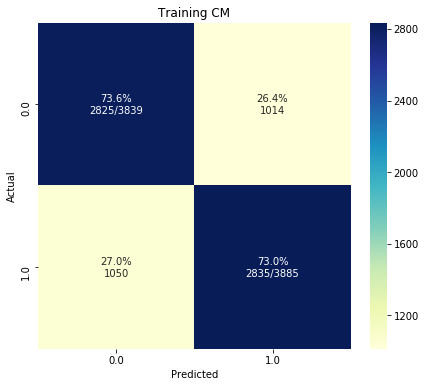

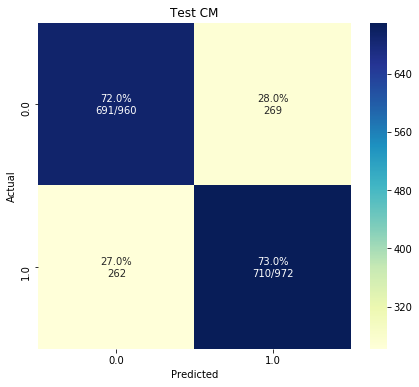

In [15]:
plot_cm(y_train,logreg_train,'Training CM')
plot_cm(y_test,logreg_pred,'Test CM')

In [16]:
#lightgbm
params = {
    'num_leaves': 100,
    'min_data_in_leaf': 75,
    'objective': 'binary',
    'max_depth': -1,
    'learning_rate': 0.007,
    "boosting_type": "gbdt",
    "bagging_seed": 7,
    "metric": 'logloss',
    "verbosity": -1,
    'random_state': 42,
}

In [17]:
dtrain = lgb.Dataset(X_train,label=y_train)
dtest = lgb.Dataset(X_test,label=y_test)

In [18]:
clf = lgb.train(params,dtrain,1000)

In [19]:
lgb_train = clf.predict(X_train)
lgb_test = clf.predict(X_test)
lgb_train = np.round(lgb_train)
lgb_test = np.round(lgb_test)

In [20]:
confusion_matrix(y_train,lgb_train)

array([[3725,  114],
       [ 118, 3767]])

In [21]:
confusion_matrix(y_test,lgb_test)

array([[685, 275],
       [270, 702]])

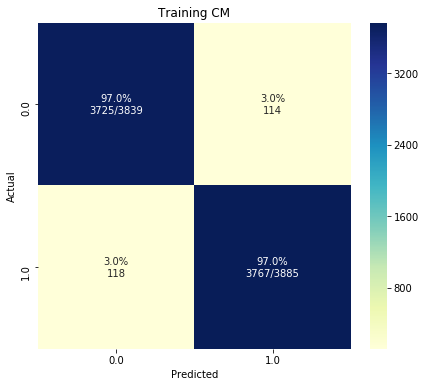

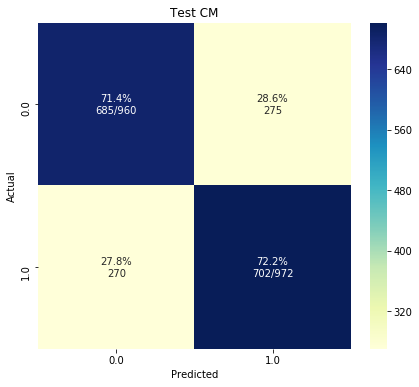

In [22]:
plot_cm(y_train,lgb_train,'Training CM')
plot_cm(y_test,lgb_test,'Test CM')

In [23]:
#xgb
params_xgb = {'max_depth':40,
              'objective':'binary:logistic',
              'min_child_weight': 75,
              'learning_rate': 0.0004,
              'eta'      :0.3,
              'subsample':0.8,
              'lambda '  :4,
              'eval_metric':'logloss',
              'n_estimators':4000,
              'colsample_bytree ':0.9,
              'colsample_bylevel':1
              }

In [24]:
dtrain = xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test,y_test)
train_set = xgb.DMatrix(X_train)
test_set = xgb.DMatrix(X_test)

In [25]:
clf = xgb.train(params_xgb, dtrain,num_boost_round=4000, verbose_eval=100)

[08:30:19] WARNING: /private/var/folders/9f/bllg8xs12w1fssb0lts4ww740000gn/T/pip-install-yfn5s9c6/xgboost/xgboost/src/learner.cc:328: 
Parameters: { colsample_bytree , lambda , n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [26]:
xgb_train = clf.predict(train_set)
xgb_test = clf.predict(test_set)
xgb_train = np.round(xgb_train)
xgb_test = np.round(xgb_test)

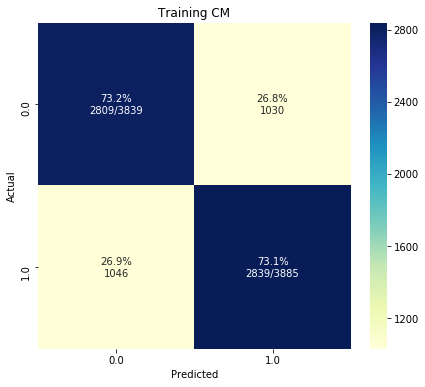

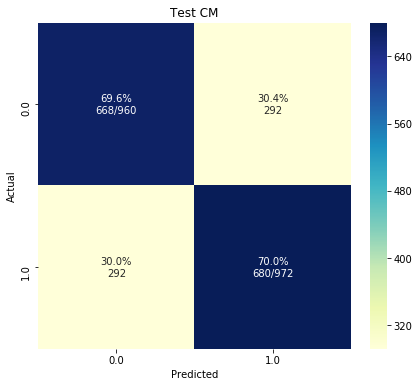

In [27]:
plot_cm(y_train,xgb_train,'Training CM')
plot_cm(y_test,xgb_test,'Test CM')

In [32]:
rf = RandomForestClassifier(n_estimators = 2000,criterion = 'gini',oob_score =True,random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [33]:
rf_train = rf.predict(X_train)
rf_test = rf.predict(X_test)

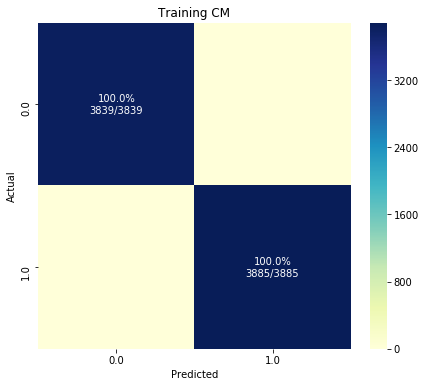

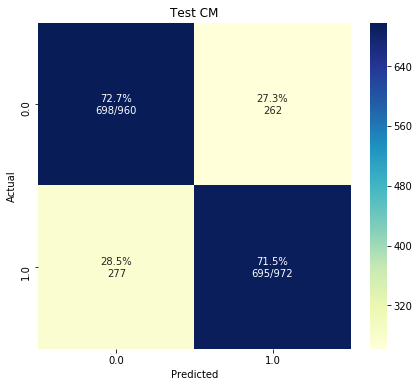

In [34]:
plot_cm(y_train,rf_train,'Training CM')
plot_cm(y_test,rf_test,'Test CM')